In [1]:
# Jupyter notebook specific imports 
import matplotlib as mpl 
from IPython import display 
%matplotlib inline

In [2]:
import numpy as np
import chaste # Core Chaste functionality
import chaste.cell_based # Chaste Cell Populations
chaste.init() # Initialize MPI and PETSc
import microvessel_chaste # Core Microvessel Chaste functionality
import microvessel_chaste.geometry # Geometry tools
import microvessel_chaste.mesh # Meshing
import microvessel_chaste.population.vessel # Vessel tools
import microvessel_chaste.pde # PDE and solvers
import microvessel_chaste.simulation # Flow and angiogenesis solvers
import microvessel_chaste.visualization # Visualization
from microvessel_chaste.utility import * # Dimensional analysis: bring in all units for convenience
# Set up the test 
chaste.cell_based.SetupNotebookTest()

In [3]:
file_handler = chaste.core.OutputFileHandler("Python/SingleChannel")
chaste.core.RandomNumberGenerator.Instance().Reseed(12345)

In [4]:
#Setting up the reference model values
reference_length = 1.e-6 * metre()
reference_time = 3600.0 * second()
reference_concentration = 1.e-9*mole_per_metre_cubed()
BaseUnits.Instance().SetReferenceLengthScale(reference_length)
BaseUnits.Instance().SetReferenceTimeScale(reference_time)
BaseUnits.Instance().SetReferenceConcentrationScale(reference_concentration)

In [5]:
#Selecting the parameters that are representative of the migration port geometry in our microfluidic device.
#The microfluidic device consists of 3 connected parts: left channel, migration port, and the right channel.
#The entire device is initially filled with gel and through passive-pumping, lumens are created in the left/right channels.
#The left channel lumen is seeded with cells - mimicking a blood vessel.
#The right channel lumen is filled with the Vascular Endothelial Growth Factor (VEGF) which acts as the attractant that
#guides the direction of the blood vessel growth/cell migration.
#These simulations primarily focus on the migration port domain.
port = microvessel_chaste.geometry.Part3() 
port_side_length = 320.0e-6 * metre()
port_side_width = 100.0e-6 * metre()
port_side_height = 100.0e-6 * metre()
originP = microvessel_chaste.mesh.DimensionalChastePoint3(0.0,0.0,0.0)
port.AddCuboid(port_side_length, port_side_width, port_side_height, originP)

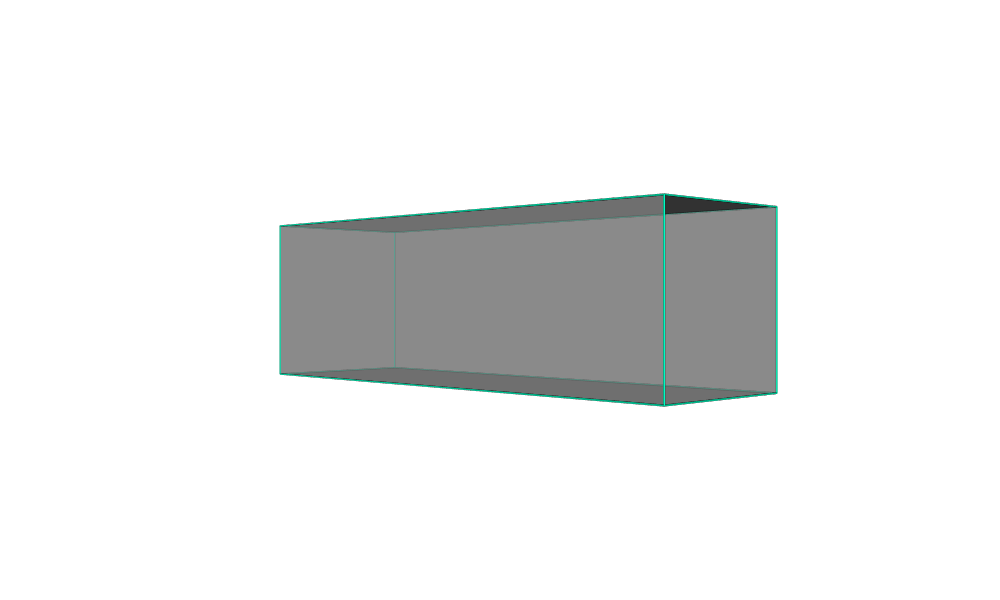

In [6]:
#Migration port domain
scene = microvessel_chaste.visualization.MicrovesselVtkScene3()
scene.SetPart(port)
scene.GetPartActorGenerator().SetVolumeOpacity(0.7)
scene.GetPartActorGenerator().SetVolumeColor((255.0, 255.0, 255.0))
nb_manager = microvessel_chaste.visualization.JupyterNotebookManager()
nb_manager.vtk_show(scene, height=600, width = 1000)

In [7]:
#Agent-based approach:
#Here we represent the experimental gel lumen structure that is seeded with cells (in the left channel) 
#by inserting a blood vessel at the corresponding location.
#The model assumes that the blood vessel is composed of individual cells which are treated as discrete entities/agents.
#Cell/agent migration is primarily governed by sensing the increasing VEGF gradient.
network_generator = microvessel_chaste.population.vessel.VesselNetworkGenerator3()
vessel_length = 100.0e-6*metre()
cell_length = 10.0e-6 * metre()
origin = microvessel_chaste.mesh.DimensionalChastePoint3(10.0, 0.0, 50.0)
network  = network_generator.GenerateSingleVessel(vessel_length, origin, int(float(vessel_length/cell_length))-1, 0)
network.GetNode(0).GetFlowProperties().SetIsInputNode(True);
network.GetNode(0).GetFlowProperties().SetPressure(Owen11Parameters.mpInletPressure.GetValue("User"))
network.GetNode(network.GetNumberOfNodes()-1).GetFlowProperties().SetIsOutputNode(True)
network.GetNode(network.GetNumberOfNodes()-1).GetFlowProperties().SetPressure(Owen11Parameters.mpOutletPressure.GetValue("User"))
nodes = network.GetNodes();
x_ctr = 0.0
for eachNode in nodes:
    new_position = microvessel_chaste.mesh.DimensionalChastePoint3(float(port_side_length*0.1/reference_length),
                                                                   float(cell_length * x_ctr/reference_length) ,
                                                                   float(port_side_height*0.5/reference_length),
                                                                   reference_length)
    x_ctr=x_ctr+1.0
    eachNode.SetLocation(new_position)

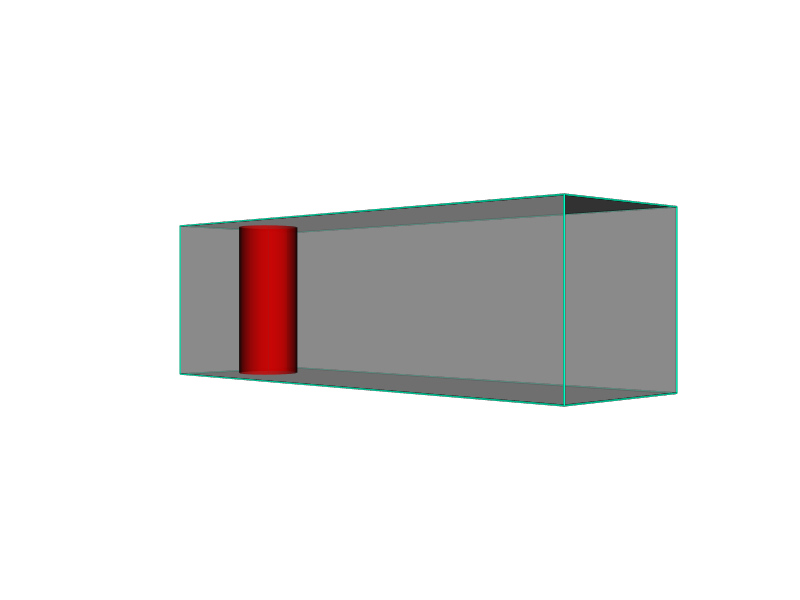

In [8]:
scene.SetVesselNetwork(network)
scene.GetVesselNetworkActorGenerator().SetEdgeSize(20.0)
nb_manager.vtk_show(scene, height=600, width = 800)

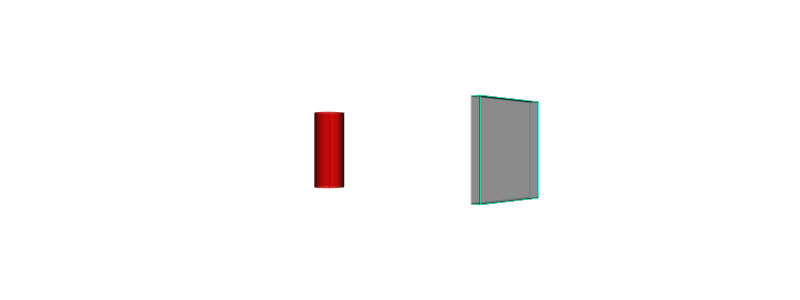

In [9]:
#Inserting the source (pellet) of the Vascular Endothelial Growth Factor (VEGF) which serves as the attractant 
#for cell migration.
pellet = microvessel_chaste.geometry.Part3()
pellet_origin_x = 310.0e-6 * metre()
pellet_origin_y = 0.0e-6 * metre()
pellet_length_x = 10.0e-6 * metre()
pellet_length_y = 100.0e-6*metre()
pellet_length_z = 100.0e-6*metre()
origin = microvessel_chaste.mesh.DimensionalChastePoint3(float(pellet_origin_x/reference_length),float(pellet_origin_y/reference_length),0.0)
pellet.AddCuboid(pellet_length_x, pellet_length_y, pellet_length_z, origin)
scene.SetPart(pellet)
scene.GetPartActorGenerator().SetVolumeOpacity(0.7)
scene.GetPartActorGenerator().SetVolumeColor((255.0, 255.0, 255.0))
nb_manager = microvessel_chaste.visualization.JupyterNotebookManager()
nb_manager.vtk_show(scene, height=300, width = 800)

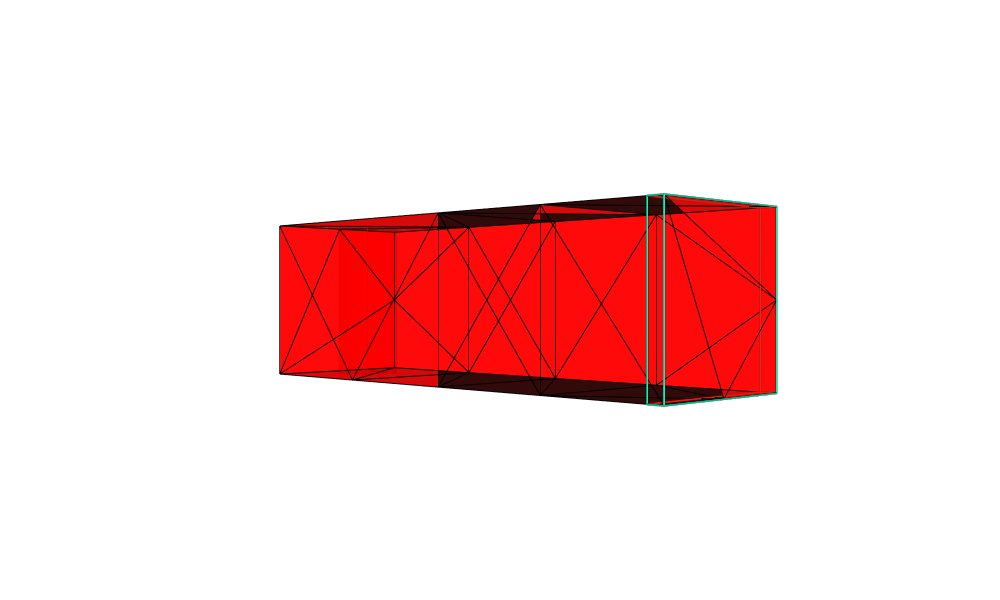

In [10]:
#Setting up the mesh to solve for the steady-state diffusion of VEGF
mesh_generator = microvessel_chaste.mesh.DiscreteContinuumMeshGenerator3_3()
mesh_generator.SetDomain(port)
mesh_generator.SetMaxElementArea(1e-7 * metre_cubed())
mesh_generator.Update()
mesh = mesh_generator.GetMesh()
scene.GetPartActorGenerator().SetVolumeOpacity(0.0)
scene.SetMesh(mesh)
nb_manager.vtk_show(scene, height=600, width = 1000)

In [11]:
#Solving the steady-state diffusion of VEGF
vegf_pde = microvessel_chaste.pde.LinearSteadyStateDiffusionReactionPde3_3()
vegf_pde.SetIsotropicDiffusionConstant(Owen11Parameters.mpVegfDiffusivity.GetValue("User"))
vegf_pde.SetContinuumLinearInUTerm(-1.0*Owen11Parameters.mpVegfDecayRate.GetValue("User"))
vegf_pde.SetMesh(mesh)
vegf_pde.SetUseRegularGrid(False)
vegf_pde.SetReferenceConcentration(1.e-9*mole_per_metre_cubed())

In [12]:
#Imposing a constant concentration VEGF (Dirichlet) BC using the source (pellet) at the right end of the domain 
vegf_boundary = microvessel_chaste.pde.DiscreteContinuumBoundaryCondition3()
vegf_boundary.SetType(microvessel_chaste.pde.BoundaryConditionType.IN_PART)
vegf_boundary.SetSource(microvessel_chaste.pde.BoundaryConditionSource.PRESCRIBED)
vegf_boundary.SetValue(3.25e-6*mole_per_metre_cubed())
vegf_boundary.SetDomain(pellet)

In [13]:
vegf_solver = microvessel_chaste.pde.FiniteElementSolver3()
vegf_solver.SetPde(vegf_pde)
vegf_solver.SetLabel("vegf")
vegf_solver.SetMesh(mesh)
vegf_solver.AddBoundaryCondition(vegf_boundary)

In [14]:
#Off-lattice approach refers to the fact that the model is derived from the motion equation (i.e. no grid is required).
angiogenesis_solver = microvessel_chaste.simulation.AngiogenesisSolver3()
sprouting_rule = microvessel_chaste.simulation.OffLatticeSproutingRule3() 
sprouting_rule.SetSproutingProbability(1.e6* per_second())
migration_rule = microvessel_chaste.simulation.OffLatticeMigrationRule3()
migration_rule.SetChemotacticStrength(0.1)
migration_rule.SetAttractionStrength(0.5)
sprout_velocity = (50.0e-6/(24.0*3600.0))*metre_per_second() 
migration_rule.SetSproutingVelocity(sprout_velocity)
angiogenesis_solver.SetMigrationRule(migration_rule)
angiogenesis_solver.SetSproutingRule(sprouting_rule)
sprouting_rule.SetDiscreteContinuumSolver(vegf_solver)
migration_rule.SetDiscreteContinuumSolver(vegf_solver)
angiogenesis_solver.SetVesselNetwork(network)
angiogenesis_solver.SetBoundingDomain(port)

In [15]:
microvessel_solver = microvessel_chaste.simulation.MicrovesselSolver3()
microvessel_solver.SetVesselNetwork(network)
microvessel_solver.AddDiscreteContinuumSolver(vegf_solver)
microvessel_solver.SetOutputFileHandler(file_handler)
microvessel_solver.SetOutputFrequency(2)
microvessel_solver.SetAngiogenesisSolver(angiogenesis_solver)
microvessel_solver.SetUpdatePdeEachSolve(False)

In [16]:
scene.GetDiscreteContinuumMeshActorGenerator().SetVolumeOpacity(0.3)
scene.GetDiscreteContinuumMeshActorGenerator().SetDataLabel("Nodal Values")
scene.GetVesselNetworkActorGenerator().SetEdgeSize(5.0)
scene_modifier = microvessel_chaste.visualization.JupyterMicrovesselSceneModifier3(nb_manager)
scene_modifier.SetVtkScene(scene)
scene_modifier.SetUpdateFrequency(2)
microvessel_solver.AddMicrovesselModifier(scene_modifier)

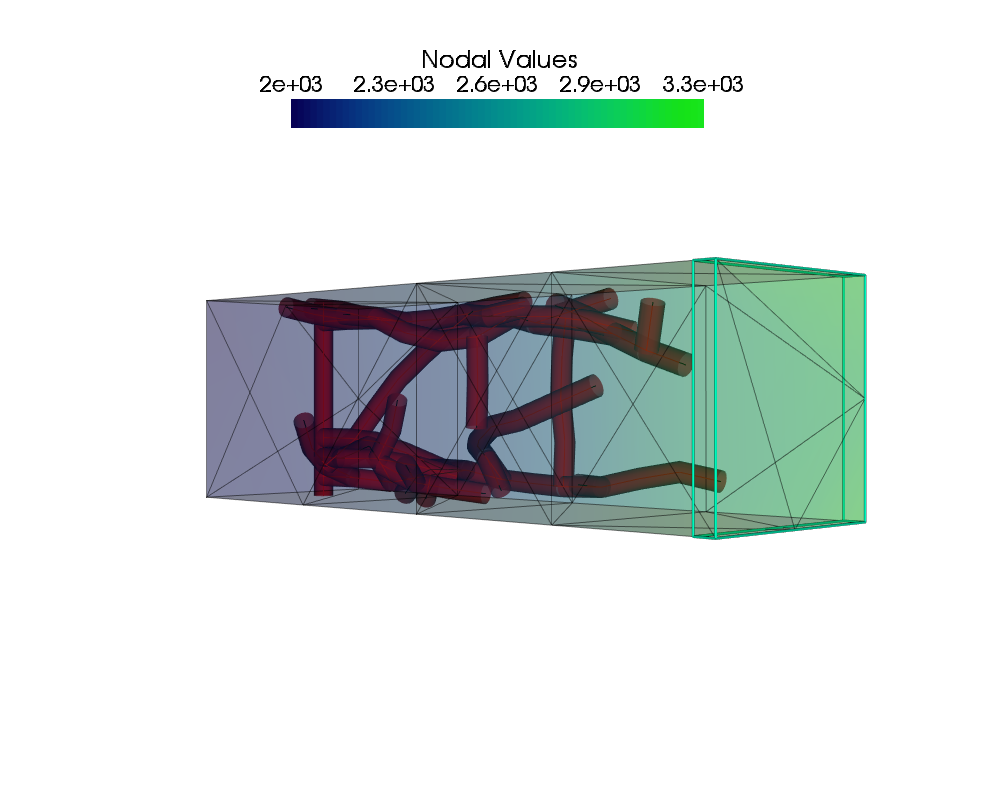

In [17]:
chaste.cell_based.SimulationTime.Instance().SetEndTimeAndNumberOfTimeSteps(120.0, 12) #EndTime [hrs]
microvessel_solver.Run()